In [2]:
import numpy as np
import os
import glob
import cv2
from random import choice
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from sklearn.preprocessing import scale,LabelEncoder,LabelBinarizer,MinMaxScaler,OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from sklearn import metrics
from scipy.stats import skew, norm
from scipy import stats
from datetime import date
from collections import Counter
import category_encoders as ce
import locale
from fuzzywuzzy import process
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from random import choices
import random
r = random.Random(101)
random.seed(101)

In [6]:
def load_house_attributes(inputPath):
 
 # load it using Pandas
    
    df = pd.read_csv(inputPath)
    #converting zip codes to object
    df.ZipCode = df.ZipCode.astype('object',copy=False)
    # dropping 'image_link','Address','Legal','Heating' columns
    df.drop(['image_link','Address','Legal','Heating'],axis=1,inplace=True)
   
  # return the data frame
    return df

In [7]:
SingleFamilyHome = load_house_attributes('../data/processed/SingleFamilyFinal.csv')

In [5]:
SingleFamilyHome.shape

(6348, 50)

In [6]:
SingleFamilyHome

,ListingPrice,City,ZipCode,County,NoBed,Stories,Style,BuildSqft,LotSize,Fireplace,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
0,364990,Houston,77003,Harris County,3,3.0,Contemporary/Modern,1736,1428.0,0,...,217000.0,192.51,2169.0,2.6554,430.000000,3,1,1195.0,1,2
1,419000,Houston,77003,Harris County,3,3.0,Traditional,2671,2006.0,1,...,443500.0,200.05,10366.0,2.5466,320.000000,3,1,2244.0,10,8
2,298800,Houston,77003,Harris County,3,1.0,Traditional,1972,5000.0,0,...,126500.0,147.06,5854.0,2.5716,616.000000,1,1,0.0,14,91
3,289900,Houston,77003,Harris County,2,2.0,Other,1688,1918.0,0,...,259000.0,181.62,6685.4,2.5465,330.000000,2,0,1500.0,14,15
4,284900,Houston,77003,Harris County,2,2.0,Traditional,1410,1845.0,0,...,259000.0,181.62,6299.0,2.5466,282.000000,2,1,1400.0,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,167000,South Houston,77587,Harris County,3,1.0,Traditional,1160,7100.0,0,...,103500.0,92.11,3108.0,2.8732,459.000000,1,1,0.0,54,57
6344,155000,South Houston,77587,Harris County,2,1.0,Traditional,839,7100.0,0,...,103500.0,92.11,2735.0,2.8732,242.916667,1,0,0.0,69,57
6345,149995,South Houston,77587,Harris County,4,1.0,Traditional,1563,7100.0,0,...,103500.0,92.11,2909.0,2.8732,441.000000,2,0,0.0,54,57
6346,137500,South Houston,77587,Harris County,3,1.0,Traditional,1461,7200.0,0,...,83500.0,118.87,2484.0,2.8732,383.000000,2,0,0.0,71,70


In [79]:
SingleFamilyHome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6348 entries, 0 to 6347
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ListingPrice         6348 non-null   int64  
 1   City                 6348 non-null   object 
 2   ZipCode              6348 non-null   object 
 3   County               6348 non-null   object 
 4   NoBed                6348 non-null   int64  
 5   Stories              6348 non-null   float64
 6   Style                6348 non-null   object 
 7   BuildSqft            6348 non-null   int64  
 8   LotSize              6348 non-null   float64
 9   Fireplace            6348 non-null   int64  
 10  Cooling              6348 non-null   object 
 11  IceMaker             6348 non-null   object 
 12  Microwave            6348 non-null   object 
 13  Compactor            6348 non-null   object 
 14  Dishwasher           6348 non-null   object 
 15  Disposal             6348 non-null   o

In [5]:
def process_house_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = train.columns[train.dtypes!='object']
    categorical = train.columns[train.dtypes=='object']
    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoing, all output features are now in the range [0, 1])
    categoricalBinarizer = ce.BinaryEncoder().fit(df[categorical])
    trainCategorical = categoricalBinarizer.transform(train[categorical])
    testCategorical = categoricalBinarizer.transform(test[categorical])

    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])

    # return the concatenated training and testing data
    return (trainX, testX)

def create_mlp(dim, regress=False):
   # define our MLP network
    model = Sequential()
    model.add(Dense(200, input_dim=dim, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation="relu"))
   # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

# return our model
    return model

In [127]:
(train, test) = train_test_split(SingleFamilyHome, test_size=0.25, random_state=101)

In [128]:
print(train.shape,test.shape)

(4761, 50) (1587, 50)


find the largest house price in the training set and use it to scale our house prices to the range [0, 1] (this will lead to better training and convergence)

In [129]:
# maxPrice = train["ListingPrice"].max()
y_train = train["ListingPrice"] 
y_test = test["ListingPrice"] 

In [130]:
train.drop('ListingPrice',axis=1,inplace=True)
test.drop('ListingPrice',axis = 1, inplace=True)

In [131]:
(X_train, X_test) = process_house_attributes(SingleFamilyHome, train, test)

In [132]:
X_train.shape

(4761, 115)

In [133]:
model = create_mlp(X_train.shape[1], regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss=losses.MeanAbsoluteError(),metrics=['mse'], optimizer=opt)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [134]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),epochs=200, batch_size=8,callbacks=[early_stopping])

Train on 4761 samples, validate on 1587 samples
Epoch 1/200
4761/4761 [==============================] - 3s 689us/sample - loss: 343354.1185 - mean_squared_error: 462595129344.0000 - val_loss: 265688.3120 - val_mean_squared_error: 514624946176.0000
Epoch 2/200
4761/4761 [==============================] - 3s 696us/sample - loss: 253886.0822 - mean_squared_error: 355894820864.0000 - val_loss: 237281.3936 - val_mean_squared_error: 467657261056.0000
Epoch 3/200
4761/4761 [==============================] - 2s 520us/sample - loss: 217657.4239 - mean_squared_error: 291960651776.0000 - val_loss: 193684.4186 - val_mean_squared_error: 383446384640.0000
Epoch 4/200
4761/4761 [==============================] - 3s 663us/sample - loss: 180471.9590 - mean_squared_error: 214253633536.0000 - val_loss: 166689.6291 - val_mean_squared_error: 294628524032.0000
Epoch 5/200
4761/4761 [==============================] - 3s 571us/sample - loss: 159745.0789 - mean_squared_error: 167121174528.0000 - val_loss: 149

Epoch 42/200
4761/4761 [==============================] - 1s 245us/sample - loss: 82206.7830 - mean_squared_error: 47234863104.0000 - val_loss: 78093.6506 - val_mean_squared_error: 82252070912.0000
Epoch 43/200
4761/4761 [==============================] - 1s 241us/sample - loss: 83483.6885 - mean_squared_error: 47504150528.0000 - val_loss: 76573.5513 - val_mean_squared_error: 81581318144.0000
Epoch 44/200
4761/4761 [==============================] - 1s 236us/sample - loss: 83019.6382 - mean_squared_error: 48586747904.0000 - val_loss: 77012.2719 - val_mean_squared_error: 79506604032.0000
Epoch 45/200
4761/4761 [==============================] - 1s 234us/sample - loss: 81515.5304 - mean_squared_error: 45373972480.0000 - val_loss: 76941.9413 - val_mean_squared_error: 78294138880.0000
Epoch 46/200
4761/4761 [==============================] - 1s 239us/sample - loss: 83110.1224 - mean_squared_error: 45886377984.0000 - val_loss: 76773.5676 - val_mean_squared_error: 80443285504.0000
Epoch 47/2

In [135]:
y_preds = model.predict(X_test)

In [144]:
result = pd.DataFrame({'ActualPrice':y_test,'PredictedPrice':y_preds.flatten()})

In [145]:
result 

,ActualPrice,PredictedPrice
684,620000,585753.750000
6250,161200,175963.359375
3122,800000,577146.000000
4011,317000,410160.531250
3161,479000,468481.562500
...,...,...
5458,249900,321660.968750
4854,239000,261452.671875
4367,234500,224850.359375
338,639900,531462.687500


In [136]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = y_preds.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
median = np.median(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] Median house price: {}, std house price: {}".format(
    locale.currency(SingleFamilyHome["ListingPrice"].median(), grouping=True),
    locale.currency(SingleFamilyHome["ListingPrice"].std(), grouping=True)))
print("[INFO] mean absolute percentage difference: {:.2f}%, std absolute percentage difference: {:.2f}%".format(median, std))

[INFO] avg. house price: $516,073.85, std house price: $636,683.19
[INFO] mean absolute percentage difference: 11.28%, std absolute percentage difference: 10.93%


In [6]:
arr = os.listdir('../data/raw/Image/')

In [7]:
len(arr)

205514

In [8]:
image_list =[]
for name in arr:
    image_list.append(int(name.split('_')[0]))
len(set(image_list))

6348

In [9]:
SingleFamilyHome.shape

(6348, 50)

In [10]:
image_count = Counter(image_list)

In [11]:
image_count.most_common()

[(5878, 98),
 (4318, 51),
 (4353, 51),
 (1005, 50),
 (1030, 50),
 (1031, 50),
 (1034, 50),
 (1039, 50),
 (1040, 50),
 (1051, 50),
 (1065, 50),
 (106, 50),
 (1095, 50),
 (1113, 50),
 (1115, 50),
 (1124, 50),
 (1254, 50),
 (1279, 50),
 (1316, 50),
 (1344, 50),
 (1356, 50),
 (1359, 50),
 (1424, 50),
 (1432, 50),
 (1434, 50),
 (1440, 50),
 (1443, 50),
 (1456, 50),
 (1457, 50),
 (1466, 50),
 (1473, 50),
 (1506, 50),
 (1509, 50),
 (1510, 50),
 (1511, 50),
 (152, 50),
 (1531, 50),
 (1537, 50),
 (1539, 50),
 (1541, 50),
 (1546, 50),
 (1568, 50),
 (156, 50),
 (1582, 50),
 (1584, 50),
 (1589, 50),
 (1590, 50),
 (15, 50),
 (1600, 50),
 (1644, 50),
 (1646, 50),
 (1671, 50),
 (1782, 50),
 (1788, 50),
 (1836, 50),
 (1863, 50),
 (1871, 50),
 (1877, 50),
 (188, 50),
 (1890, 50),
 (1891, 50),
 (1892, 50),
 (1896, 50),
 (1900, 50),
 (1902, 50),
 (1906, 50),
 (1934, 50),
 (1965, 50),
 (1983, 50),
 (1986, 50),
 (2020, 50),
 (2025, 50),
 (2027, 50),
 (2029, 50),
 (2032, 50),
 (2033, 50),
 (2035, 50),
 (203

In [3]:
def load_house_images(df, inputPath):
# initialize our images array (i.e., the house images themselves)
    images = []

    # loop over the indexes of the houses
    for i in tqdm(df.index.values):
    # find the images for the house and sort the file paths,
    # ensuring the images are always in the *same order*
        basePath = os.path.sep.join([inputPath, "{}_*".format(i)])
        housePaths = sorted(list(glob.glob(basePath)))

        # initialize our list of input images along with the output image
        # after *combining* the four input images
        if len(housePaths) < 36:
            housePaths = choices(housePaths,k=36)
        else:
            housePaths = random.sample(housePaths, 36)
        inputImages = []
    
        for housePath in housePaths:
       
    # load the input image, resize it to be 32 32, and then
    # update the list of input images
            image = cv2.imread(housePath)
            image = cv2.resize(image, (32, 32))
            inputImages.append(image)
            Image_list = [inputImages[i:i+6] for i in range(0, len(inputImages), 6)]
        # add the tiled image to our set of images the network will be
        # trained on
        outputImage = cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in Image_list])
        images.append(outputImage)
        # return our set of images
    return np.array(images)

In [4]:
def create_cnn(width, height, depth, filters=(16,32,64,128), regress=False):
# initialize the input shape and channel dimension, assuming
# TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

 # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same",kernel_regularizer=regularizers.l2(l=0.01),
                   kernel_initializer='he_normal')(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(100)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(50)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [8]:
images = load_house_images(SingleFamilyHome, '../data/raw/Image/')

100%|████████████████████████████████████████████████████████████████████████████| 6348/6348 [1:20:01<00:00,  1.32it/s]


In [9]:
images = images / 255.0

In [10]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(SingleFamilyHome, images, test_size=0.25, random_state=101)

In [11]:
maxPrice = trainAttrX["ListingPrice"].max()
trainY = trainAttrX["ListingPrice"]/ maxPrice
testY = testAttrX["ListingPrice"]/ maxPrice

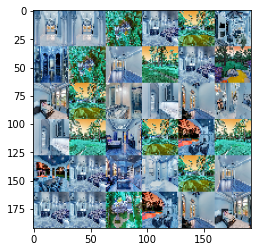

In [12]:
 plt.imshow(trainImagesX[0])

In [13]:
model = create_cnn(192, 192, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss=losses.MeanAbsoluteError(),metrics=['mse'], optimizer=opt)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 192, 192, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0     

In [15]:
model.fit(x=trainImagesX, y=trainY,validation_data=(testImagesX, testY),epochs=200, batch_size=10,callbacks=[early_stopping])

Train on 4761 samples, validate on 1587 samples
Epoch 1/200
4761/4761 [==============================] - 409s 86ms/sample - loss: 3.5166 - mean_squared_error: 0.2291 - val_loss: 2.1657 - val_mean_squared_error: 0.4543
Epoch 2/200
4761/4761 [==============================] - 408s 86ms/sample - loss: 1.3568 - mean_squared_error: 0.0630 - val_loss: 0.8504 - val_mean_squared_error: 0.0303
Epoch 3/200
4761/4761 [==============================] - 405s 85ms/sample - loss: 0.5845 - mean_squared_error: 0.0213 - val_loss: 0.3668 - val_mean_squared_error: 0.0100
Epoch 4/200
4761/4761 [==============================] - 405s 85ms/sample - loss: 0.2972 - mean_squared_error: 0.0098 - val_loss: 0.2465 - val_mean_squared_error: 0.0117
Epoch 5/200
4761/4761 [==============================] - 430s 90ms/sample - loss: 0.1810 - mean_squared_error: 0.0066 - val_loss: 0.1364 - val_mean_squared_error: 0.0070
Epoch 6/200
4761/4761 [==============================] - 431s 91ms/sample - loss: 0.1582 - mean_square

In [20]:
# make predictions on the testing data

preds = model.predict(testImagesX)

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] median house price: {}, std house price: {}".format(
	locale.currency(SingleFamilyHome["ListingPrice"].median(), grouping=True),
	locale.currency(SingleFamilyHome["ListingPrice"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] median house price: $339,000.00, std house price: $636,683.19
[INFO] mean: 41.61%, std: 30.55%


In [23]:
ordinal = OrdinalEncoder()

In [24]:
SingleFamilyHome[categorical] = ordinal.fit_transform(SingleFamilyHome[categorical])

In [25]:
SingleFamilyHome.head()

,ListingPrice,City,ZipCode,County,NoBed,Stories,Style,BuildSqft,LotSize,Fireplace,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
0,364990,2.0,0.0,1.0,3,3.0,1.0,1736,1428.0,0,...,217000.0,192.51,2169.0,2.6554,430.0,3,1,1195.0,1,2
1,419000,2.0,0.0,1.0,3,3.0,14.0,2671,2006.0,1,...,443500.0,200.05,10366.0,2.5466,320.0,3,1,2244.0,10,8
2,298800,2.0,0.0,1.0,3,1.0,14.0,1972,5000.0,0,...,126500.0,147.06,5854.0,2.5716,616.0,1,1,0.0,14,91
3,289900,2.0,0.0,1.0,2,2.0,10.0,1688,1918.0,0,...,259000.0,181.62,6685.4,2.5465,330.0,2,0,1500.0,14,15
4,284900,2.0,0.0,1.0,2,2.0,14.0,1410,1845.0,0,...,259000.0,181.62,6299.0,2.5466,282.0,2,1,1400.0,15,15


In [26]:
SingleFamilyHome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6348 entries, 0 to 6347
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ListingPrice         6348 non-null   int64  
 1   City                 6348 non-null   float64
 2   ZipCode              6348 non-null   float64
 3   County               6348 non-null   float64
 4   NoBed                6348 non-null   int64  
 5   Stories              6348 non-null   float64
 6   Style                6348 non-null   float64
 7   BuildSqft            6348 non-null   int64  
 8   LotSize              6348 non-null   float64
 9   Fireplace            6348 non-null   int64  
 10  Cooling              6348 non-null   float64
 11  IceMaker             6348 non-null   int64  
 12  Microwave            6348 non-null   int64  
 13  Compactor            6348 non-null   int64  
 14  Dishwasher           6348 non-null   int64  
 15  Disposal             6348 non-null   i

In [27]:
X = SingleFamilyHome.drop('ListingPrice',axis=1)
y = SingleFamilyHome['ListingPrice']

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=101)

In [32]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4443, 49) (1905, 49) (4443,) (1905,)


In [49]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [50]:
rf = RandomForestRegressor(random_state=101)

In [51]:
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid,  cv = 3, verbose=2, n_jobs = 5,scoring='neg_mean_squared_error')
# Fit the random search model
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   51.3s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  9.1min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 15.8min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed: 26.0min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 40.1min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed: 55.4min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed: 70.9min
[Parallel(n_jobs=5)]: Done 3271 tasks      | elapsed: 88.4min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 113.0min
[Parallel(n_jobs=5)]: Done 4891 tasks      | elapsed: 132.4min
[Parallel(n_jobs=5)]: Done 5822 tasks      | elapsed: 158.7min
[Parallel(n_jobs=5)]: Done 6835 tasks      | elapsed: 188.0min
[Parallel(n_jobs=5)]: Done 7928 tasks      | elapsed: 232.0min
[Parallel(n_jobs=5)]: Done 9103 tasks      | elapsed: 27

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=101), n_jobs=5,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 122, 144, 166, 188, 211, 233,
                                          255, 277, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [52]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=211,
                      random_state=101)

In [53]:
best_model = RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=211,
                      random_state=101)

In [54]:
best_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=211,
                      random_state=101)

In [56]:
y_predict = best_model.predict(X_test)

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [58]:
mean_squared_error(y_test,y_predict)

72160461493.72536

In [60]:
mean_absolute_error(y_test,y_predict)

72115.59982074665

In [61]:
best_model.feature_importances_

array([4.38044514e-04, 2.82532489e-03, 3.77084825e-05, 1.75303196e-03,
       1.82221129e-03, 9.55909347e-04, 1.75324779e-02, 1.33670802e-02,
       1.26040237e-03, 1.71991410e-04, 7.87650049e-04, 1.32105907e-04,
       2.17054491e-05, 6.53164537e-05, 4.96478131e-05, 1.21711348e-03,
       7.09596116e-04, 1.17829215e-03, 1.51523001e-03, 3.26089522e-04,
       6.40582056e-04, 1.21279259e-04, 1.22240427e-04, 4.38212836e-06,
       5.08124430e-04, 2.03314960e-03, 1.19658405e-03, 2.07454165e-04,
       2.51934497e-03, 5.92989230e-03, 2.67722049e-03, 2.63654006e-03,
       8.87443743e-04, 2.76334408e-03, 3.16300723e-03, 4.60739746e-03,
       1.08081400e-03, 7.91603417e-03, 2.24450091e-03, 3.08342940e-02,
       4.58205829e-03, 8.36954269e-01, 5.81627307e-03, 4.25581047e-03,
       3.45365614e-03, 2.33736078e-03, 3.61154179e-03, 1.79751593e-02,
       2.75331232e-03])

In [64]:
SingleFamilyHome.columns

Index(['ListingPrice', 'City', 'ZipCode', 'County', 'NoBed', 'Stories',
       'Style', 'BuildSqft', 'LotSize', 'Fireplace', 'Cooling', 'IceMaker',
       'Microwave', 'Compactor', 'Dishwasher', 'Disposal', 'Roof',
       'Foundation', 'PrivatePool', 'ExteriorType', 'LotDes', 'ControlAccess',
       'WaterSewer', 'AreaPool', 'DwellingType', 'HOA', 'AvgBed', 'AvgBaths',
       'CarportDescription', 'UtilitySqft', 'StudySqft', 'GameSqft',
       'BreakfastSqft', 'Garage', 'LivingSqft', 'DiningSqft', 'KitchenSqft',
       'SubName', 'MedianApp', 'MedianSqft', 'AvgNeighborValRange',
       'MedianPrice/Sqft', 'PaidTax', 'TaxRate', 'TotalBedSqft', 'FullBath',
       'HalfBath', 'MaintenanceFee', 'Age', 'MedianAge'],
      dtype='object')

<BarContainer object of 49 artists>

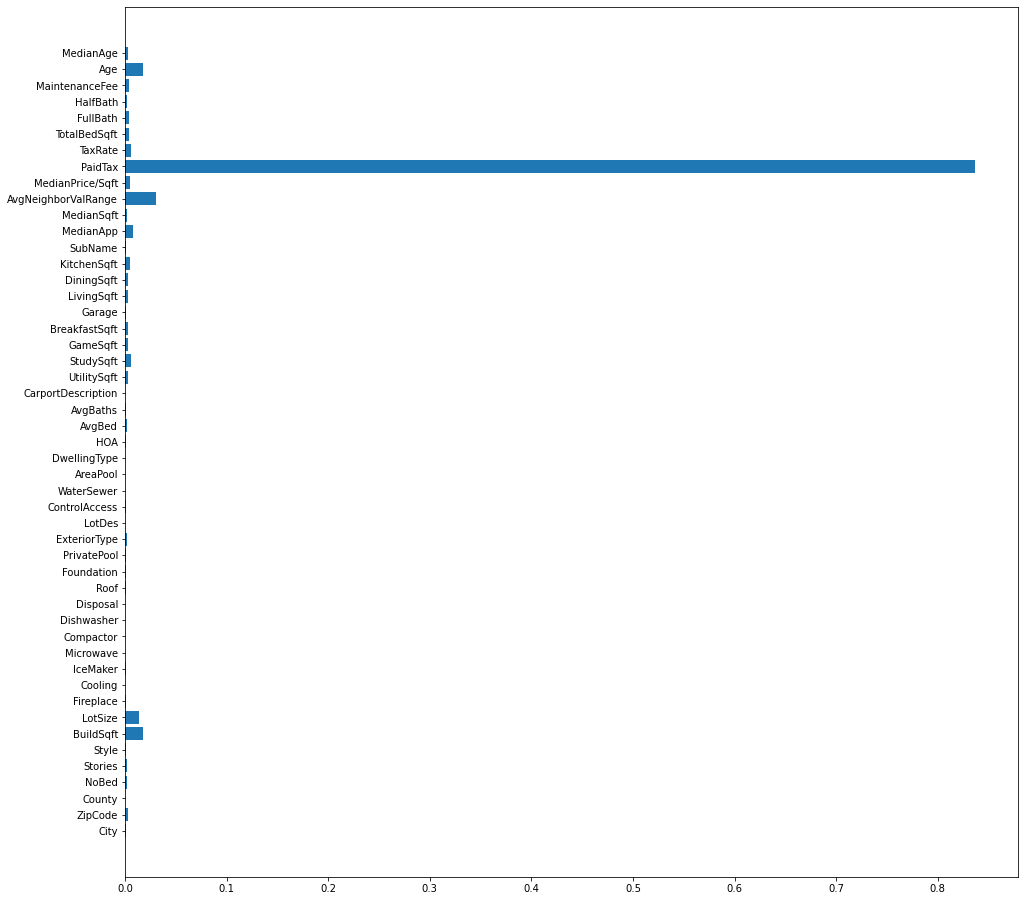

In [68]:
plt.figure(figsize=(16,16))
plt.barh(X.columns, best_model.feature_importances_)